<a href="https://colab.research.google.com/github/LokeshSreenathJ/Transformers/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.utils.data as dataloader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Data transformation for converting PIL to tensor format

In [2]:
data_transformation = transforms.Compose([transforms.ToTensor()])

In [3]:
train_dataset = torchvision.datasets.MNIST(root="./data", train = True, download=True, transform = data_transformation)
val_dataset = torchvision.datasets.MNIST(root="./data", train = False, download=True, transform = data_transformation)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 554kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


Variables info

In [4]:
img_size = 28
num_channels = 1 #since it's grey scale image
patch_size = 7
num_patches = (img_size//patch_size)**2
token_dim = 32 # can be a any values, this represents how we are projecting a patch of a image into numeric vectors
num_heads = 4
transfomer_blocks = 4
batch_size = 64
num_clases = 10
mlp_hidden_dim = 64 # can be tweakable
learning_rate = 3e-4
epochs = 5

In [5]:
train_loader = dataloader.DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = dataloader.DataLoader(val_dataset, batch_size=64, shuffle=False)

Part 1 of ViT : Patch Embedding

In [15]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__() # this is initialize the parent class (nn.module) instance variables
    self.patch_embed = nn.Conv2d(num_channels, token_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self,x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x

Part 2 of ViT : Transformers Encoder

In [23]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(token_dim)
    self.layernorm2 = nn.LayerNorm(token_dim)
    self.multihead_attention = nn.MultiheadAttention(token_dim, num_heads=num_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(token_dim, mlp_hidden_dim),
        nn.GELU(),
        nn.Linear(mlp_hidden_dim, token_dim)
    )

  def forward(self,x):

    residual1 = x
    x = self.layernorm1(x)
    x = self.multihead_attention(x,x,x)[0]
    x = x+ residual1

    residual2 = x
    x = self.layernorm2(x)
    x = self.mlp(x)
    x = x + residual2

    return x




Part 3 of ViT : MLP Classification head

In [24]:
class MLPHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm = nn.LayerNorm(token_dim)
    self.mlp = nn.Linear(token_dim, num_clases)

  def forward(self,x):
    x = self.layernorm(x)
    x = self.mlp(x)

    return x  #output are logits


Part 1,2,3 combined

In [25]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1,token_dim))
    self.position_encoding = nn.Parameter(torch.randn(1,num_patches+1,token_dim))
    self.transformer_blocks = nn.Sequential(*(TransformerEncoder() for _ in range(transfomer_blocks)))
    self.mlphead = MLPHead()

  def forward(self,x):
    x = self.patch_embedding(x)
    B = x.shape[0]
    cls_token = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_token,x), dim=1)
    x = x + self.position_encoding

    x = self.transformer_blocks(x)
    x = x[:,0]
    x = self.mlphead(x)

    return x

Device, model, optimizer and loss

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

In [27]:
for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"\nEpoch {epoch+1}")

  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    preds = outputs.argmax(dim=1)
    correct = (preds == labels).sum().item()
    accuracy = 100.0 * correct / labels.size(0)

    correct_epoch += correct
    total_epoch += labels.size(0)

    if batch_idx % 100 == 0:
        print(
            f"Batch {batch_idx+1:03d}: "
            f"Loss = {loss.item():.4f}, "
            f"Accuracy = {accuracy:.2f}%"
        )
epoch_acc = 100.0 * correct_epoch / total_epoch
print(
    f"Epoch Summary: "
    f"Total Loss = {total_loss:.4f}, "
    f"Accuracy = {epoch_acc:.2f}%"
)




Epoch 1
Batch 001: Loss = 2.4773, Accuracy = 6.25%
Batch 101: Loss = 2.1119, Accuracy = 29.69%
Batch 201: Loss = 1.0058, Accuracy = 75.00%
Batch 301: Loss = 0.7249, Accuracy = 89.06%
Batch 401: Loss = 0.4232, Accuracy = 92.19%
Batch 501: Loss = 0.3604, Accuracy = 93.75%
Batch 601: Loss = 0.3649, Accuracy = 90.62%
Batch 701: Loss = 0.4484, Accuracy = 85.94%
Batch 801: Loss = 0.2330, Accuracy = 95.31%
Batch 901: Loss = 0.4481, Accuracy = 87.50%

Epoch 2
Batch 001: Loss = 0.1363, Accuracy = 98.44%
Batch 101: Loss = 0.2815, Accuracy = 93.75%
Batch 201: Loss = 0.2590, Accuracy = 90.62%
Batch 301: Loss = 0.2293, Accuracy = 93.75%
Batch 401: Loss = 0.1811, Accuracy = 96.88%
Batch 501: Loss = 0.0897, Accuracy = 98.44%
Batch 601: Loss = 0.2153, Accuracy = 90.62%
Batch 701: Loss = 0.1347, Accuracy = 98.44%
Batch 801: Loss = 0.2013, Accuracy = 93.75%
Batch 901: Loss = 0.1017, Accuracy = 96.88%

Epoch 3
Batch 001: Loss = 0.1593, Accuracy = 95.31%
Batch 101: Loss = 0.1989, Accuracy = 95.31%
Batch 

In [28]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = 100.0 * correct / total
print(f"==> Val Accuracy: {val_acc:.2f}%")


==> Val Accuracy: 96.70%


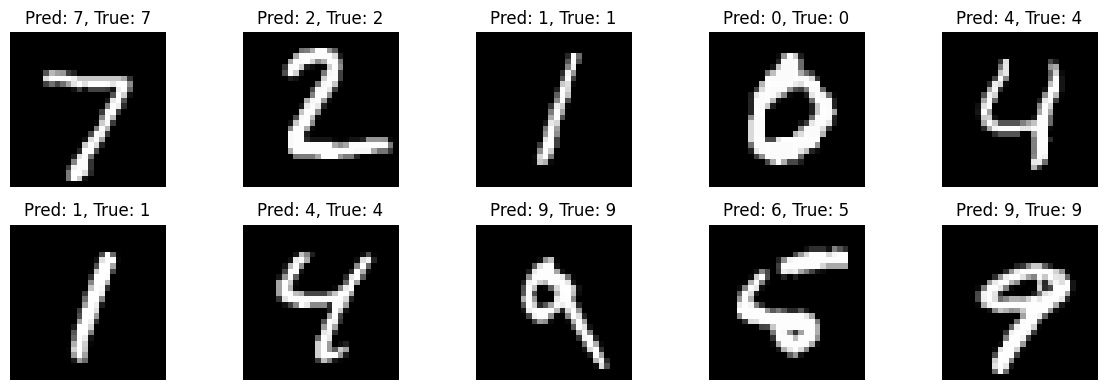

In [29]:
import matplotlib.pyplot as plt

# Show 10 predictions from the first test batch
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Move to CPU for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Plot first 10 images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i]}, True: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
